# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

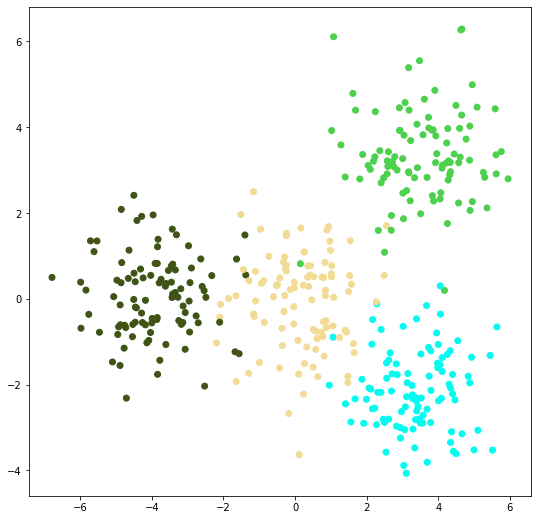

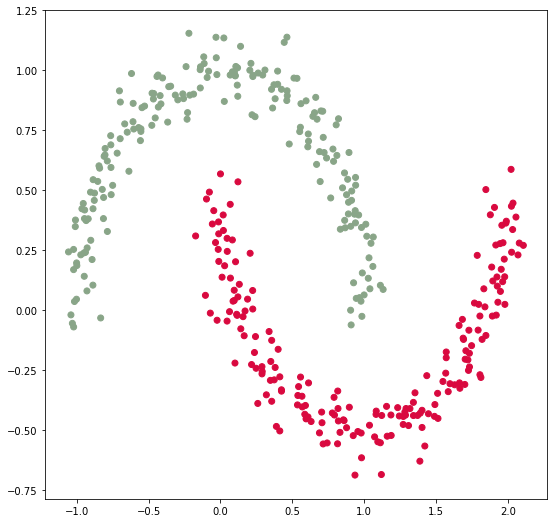

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
def random_init(X, k):
    
    centroids = np.random.uniform(np.min(X[:,0]), np.max(X[:,0]), size=(k,1))
    for i in range(1, X.shape[1]):
        centroids = np.hstack((centroids, np.random.uniform(np.min(X[:,i]), np.max(X[:,i]), size=(k,1))))
        
    return centroids

def sample_init(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False)]

def k_means_pp(X, k):
    N = X.shape[0]
    centroids = X[np.random.choice(N)].reshape(1,-1)
    nearest_dists = np.zeros(shape=(N))
    for _ in range(k-1):
        for i, x in enumerate(X):
            dists = np.linalg.norm(centroids - x, axis=1)
            nearest_dists[i] = np.min(dists)        
        squared_nd = nearest_dists**2
        probabilities = squared_nd / sum(squared_nd)
        new_centroid_ind = np.random.choice(N, p=probabilities)
        centroids = np.concatenate((centroids, X[new_centroid_ind].reshape(1,-1)), axis=0)
    return centroids

In [5]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.k = n_clusters
        self.init = init
        self.max_iter = max_iter
        
    def centroids_init(self, X, k, init):
        if init == 'random':
            return random_init(X, k)
        if init == 'sample':
            return sample_init(X, k)
        if init == 'k_means_pp':
            return k_means_pp(X, k)
        
    def fit(self, X, y=None):
        
        centroids = self.centroids_init(X, self.k, self.init)
        dists = [np.linalg.norm(X - centroid, axis=1) for centroid in centroids]
        y0 = np.argmin(dists, axis=0)
        conv = 1        
        it = 0
        
        while (conv > 1e-6) and (it < self.max_iter):
            for i in range(self.k):
                arg_points = y0 == i
                n_points = np.sum(y0 == i)
                if n_points:
                    centroids[i] = np.sum(X[arg_points], axis=0) / n_points 
            
            dists = [np.linalg.norm(X - centroid, axis=1) for centroid in centroids]
            y = np.argmin(dists, axis=0)
            
            conv = np.sum(y0-y)
            y0 = y
            it += 1
        
        self.centroids = centroids
        
        return y
    
    def predict(self, X):
        dists = [np.linalg.norm(X - centroid, axis=1) for centroid in self.centroids]
        return np.argmin(dists, axis=0)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

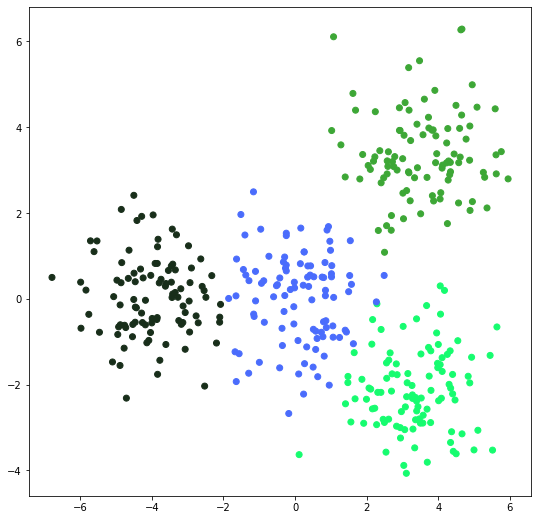

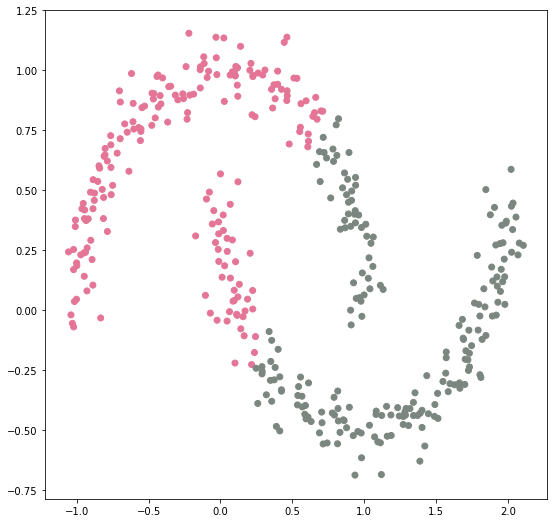

In [13]:
kmeans = KMeans(n_clusters=4, init='k_means_pp')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k_means_pp')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [14]:
import sklearn

In [15]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        
        KDTree = sklearn.neighbors.KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        count = KDTree.query_radius(X, self.eps, count_only=True, return_distance=False)
        inds, dists = KDTree.query_radius(X, self.eps, return_distance=True)
        
        centroids = np.arange(X.shape[0])
        cores = count >= self.min_samples
        core_samples = centroids[cores]
        core_neighbors = inds[core_samples]
        for core, neighbors in zip(core_samples, core_neighbors):
            centroids[neighbors] = centroids[core]
                
        label_names = np.unique(centroids)
        new_labels = dict(zip(label_names, np.arange(label_names.size)))
        labels = [new_labels[centroid] for centroid in centroids]
        
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

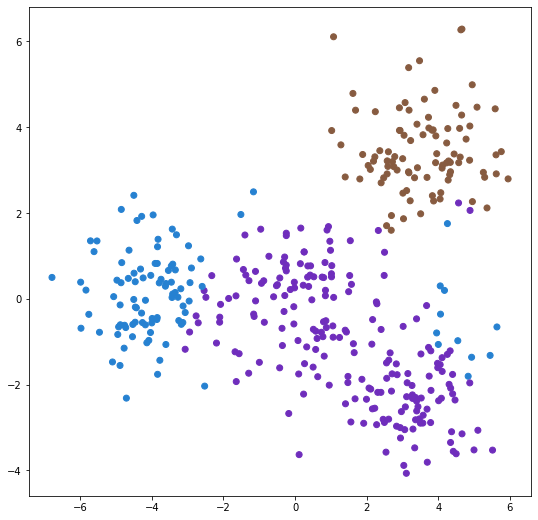

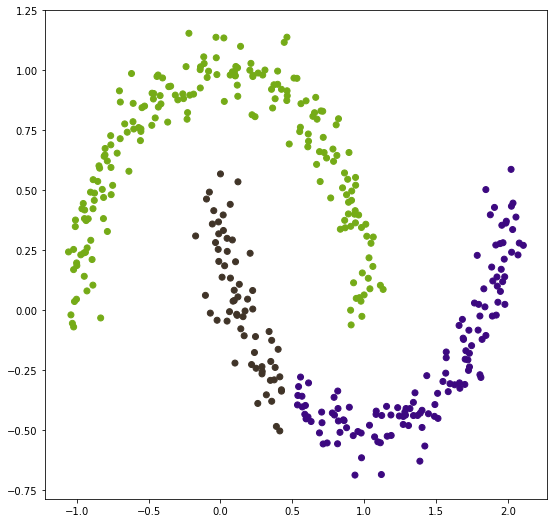

In [17]:
dbscan = DBScan(eps=1.5, metric='euclidean')
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.35, min_samples=5, metric='euclidean')
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [31]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        self.linkage = linkage
    
    def Linkage(self, cluster1, cluster2, linkage='average'):
        if linkage == 'average':
            result = 0
            for point in self.X[cluster1]:
                result += np.sum(np.linalg.norm(self.X[cluster2] - point, axis=1))
            result = result / (len(cluster1) * len(cluster2))
            return result  
        
        if linkage == 'single':
            min_dist = float('inf')
            for point in self.X[cluster1]:
                min_dist = min(min_dist, *np.linalg.norm(self.X[cluster2] - point, axis=1))
            return min_dist
        
        if linkage == 'complete':
            max_dist = 0
            for point in self.X[cluster1]:
                max_dist = max(max_dist, *np.linalg.norm(self.X[cluster2] - point, axis=1))
            return max_dist    
    
    def fit_predict(self, X, y=None):
        s0 = time.perf_counter()
        N = X.shape[0]
        self.X = X
        clusters = np.arange(X.shape[0]).reshape(-1,1).tolist()

        for _ in range(N - self.n_clusters):
            min_dist = float('inf')
            merged_clusters = (-1, -1)
            for i, cluster1 in enumerate(clusters):
                if cluster1 is None:
                    continue
                for j, cluster2 in enumerate(clusters[i+1:]):
                    if cluster2 is None:
                        continue
                    dist = self.Linkage(cluster1, cluster2, linkage=self.linkage)
                    if min_dist > dist:
                        min_dist = dist
                        merged_clusters = (i, i + j + 1)
                        
            clusters[merged_clusters[0]] = np.concatenate((clusters[merged_clusters[0]], 
                                                          clusters[merged_clusters[1]]), axis=0)
            #clusters[merged_clusters[1]] = None
            del clusters[merged_clusters[1]]
        
        labels = np.zeros(shape=N, dtype=int)
        i = 0
        for cl in clusters:
            if cl is None:
                continue
            labels[cl] = i
            i += 1
            
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

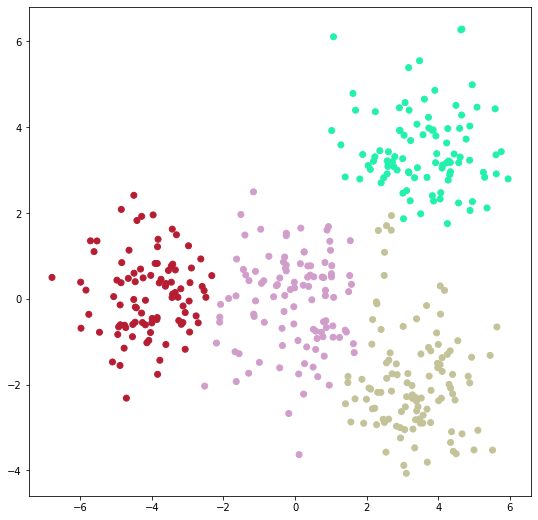

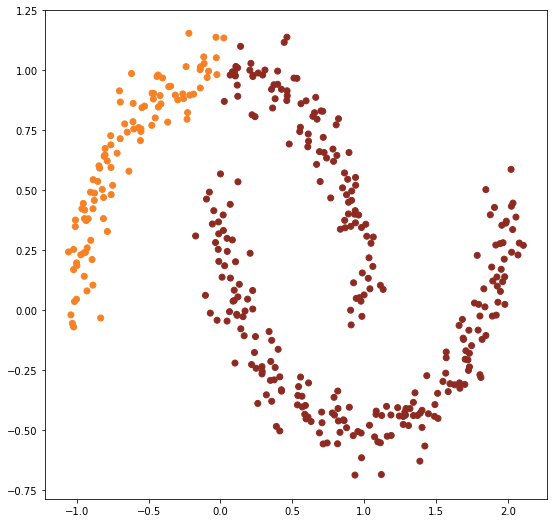

In [32]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [46]:
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def show_image(image):
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image, path):
    cv2.imwrite(image, path)

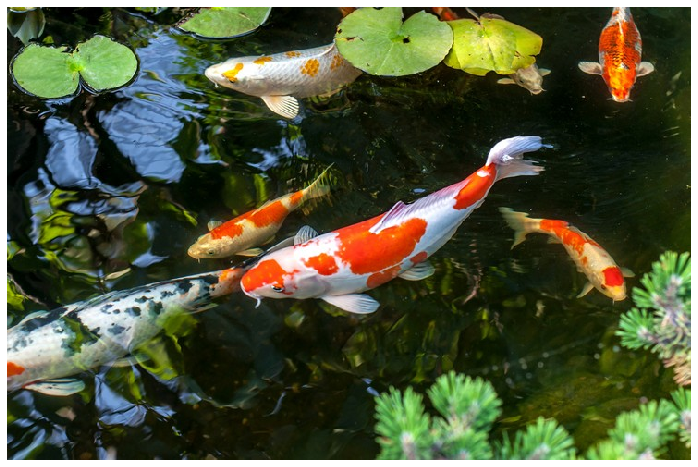

In [47]:
show_image(read_image("./koi.jpg"))

In [48]:
def clusterize_image(image, **kwargs):
    kmeans = KMeans(n_clusters=8, max_iter=100)
    kmeans.fit(image.reshape(-1, 3))
    cluster_colors = kmeans.predict(image.reshape(-1, 3))
    clusters = kmeans.centroids.astype(int) # Cluster labels for each pixel in flattened image
    recolored = clusters[cluster_colors].reshape(image.shape) # Image with pixel colors assigned to corresponding cluster colors
    
    #clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

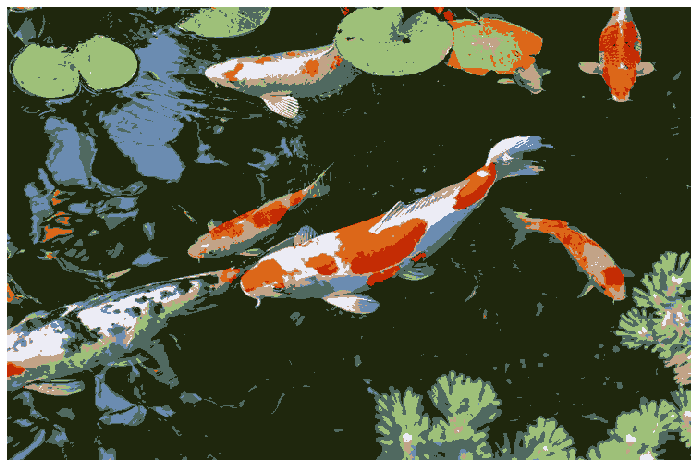

SystemError: <built-in function imwrite> returned NULL without setting an error

In [49]:
image = read_image("./koi.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")